**Project Overview**

This project forecasts geospatial climate-related risk in the Phoenix region using satellite and weather data from the Microsoft Planetary Computer. The objective is to train a deep learning model that can detect and monitor temporal-spatial patterns of environmental hazard risk (e.g., fire, drought).

**Data Acquisition & Preprocessing**

Sources Used:

* GridMET dataset from the Microsoft Planetary Computer

* Phoenix city boundary shapefile via REST API

Key Steps:

* Data was accessed using the pystac_client to retrieve Zarr-format weather data

* Clipped to Phoenix boundaries using geopandas

* Selected 12 core variables relevant to environmental risk: temperature, fuel moisture, humidity, wind, radiation, etc.

* Time slice: 2017–2020

* Weekly resampling to reduce dimensionality and align with decision-making timeframes

Output: 

* xarray.Dataset → weekly_ds → aggregated_df containing rows per week per coordinate

In [2]:
# SECTION 1: Setup and Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr
import pystac_client
import planetary_computer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

sns.set(style="whitegrid")

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import pystac_client
import planetary_computer

catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

asset = catalog.get_collection("gridmet").assets["zarr-abfs"]
asset

<Asset href=abfs://gridmet/gridmet.zarr>

In [4]:
import xarray as xr
ds = xr.open_dataset(
    asset.href,
    engine="zarr",
    storage_options=asset.extra_fields.get("xarray:storage_options", {}),
    **asset.extra_fields.get("xarray:open_kwargs", {})
)
ds

<xarray.Dataset> Size: 597GB
Dimensions:                                    (time: 15341, lat: 585,
                                                lon: 1386, crs: 1)
Coordinates:
  * crs                                        (crs) uint16 2B 3
  * lat                                        (lat) float64 5kB 49.4 ... 25.07
  * lon                                        (lon) float64 11kB -124.8 ... ...
  * time                                       (time) datetime64[ns] 123kB 19...
Data variables:
    air_temperature                            (time, lat, lon) float32 50GB ...
    burning_index_g                            (time, lat, lon) float32 50GB ...
    dead_fuel_moisture_1000hr                  (time, lat, lon) float32 50GB ...
    dead_fuel_moisture_100hr                   (time, lat, lon) float32 50GB ...
    mean_vapor_pressure_deficit                (time, lat, lon) float32 50GB ...
    potential_evapotranspiration               (time, lat, lon) float32 50GB ...
    precipitation_amount                       (time, lat, lon) float32 50GB ...
    relative_humidity                          (time, lat, lon) float32 50GB ...
    specific_humidity                          (time, lat, lon) float32 50GB ...
    surface_downwelling_shortwave_flux_in_air  (time, lat, lon) float32 50GB ...
    wind_from_direction                        (time, lat, lon) float32 50GB ...
    wind_speed                                 (time, lat, lon) float32 50GB ...
Attributes: (12/19)
    Conventions:                CF-1.6
    author:                     John Abatzoglou - University of Idaho, jabatz...
    coordinate_system:          EPSG:4326
    date:                       02 July 2019
    geospatial_bounds:          POLYGON((-124.7666666333333 49.40000000000000...
    geospatial_bounds_crs:      EPSG:4326
    ...                         ...
    geospatial_lon_units:       decimal_degrees east
    note1:                      The projection information for this file is: ...
    note2:                      Citation: Abatzoglou, J.T., 2013, Development...
    note3:                      Data in slices after last_permanent_slice (1-...
    note4:                      Data in slices after last_provisional_slice (...
    note5:                      Days correspond approximately to calendar day...

In [5]:
import geopandas as gpd

# Define the REST API endpoint with parameters to return GeoJSON
url = (
    "https://maps.phoenix.gov/pub/rest/services/Public/CityBoundary/MapServer/0/query"
    "?where=1%3D1&outFields=*&f=geojson"
)

# Read the GeoJSON data into a GeoDataFrame
phoenix = gpd.read_file(url)

# Ensure the coordinate reference system is set to WGS84
phoenix = phoenix.to_crs("EPSG:4326")

In [6]:
VARIABLES = [
    "air_temperature", "burning_index_g", "dead_fuel_moisture_100hr",
    "dead_fuel_moisture_1000hr", "mean_vapor_pressure_deficit", "potential_evapotranspiration",
    "precipitation_amount", "relative_humidity", "specific_humidity",
    "surface_downwelling_shortwave_flux_in_air", "wind_from_direction", "wind_speed"
]

In [7]:
ds=ds[VARIABLES].sel(time=slice("2017-01-01", None))

In [8]:
ds.rio.write_crs("EPSG:4326", inplace=True)

<xarray.Dataset> Size: 57GB
Dimensions:                                    (time: 1461, lat: 585, lon: 1386)
Coordinates:
  * lat                                        (lat) float64 5kB 49.4 ... 25.07
  * lon                                        (lon) float64 11kB -124.8 ... ...
  * time                                       (time) datetime64[ns] 12kB 201...
    crs                                        int32 4B 0
Data variables:
    air_temperature                            (time, lat, lon) float32 5GB ...
    burning_index_g                            (time, lat, lon) float32 5GB ...
    dead_fuel_moisture_100hr                   (time, lat, lon) float32 5GB ...
    dead_fuel_moisture_1000hr                  (time, lat, lon) float32 5GB ...
    mean_vapor_pressure_deficit                (time, lat, lon) float32 5GB ...
    potential_evapotranspiration               (time, lat, lon) float32 5GB ...
    precipitation_amount                       (time, lat, lon) float32 5GB ...
    relative_humidity                          (time, lat, lon) float32 5GB ...
    specific_humidity                          (time, lat, lon) float32 5GB ...
    surface_downwelling_shortwave_flux_in_air  (time, lat, lon) float32 5GB ...
    wind_from_direction                        (time, lat, lon) float32 5GB ...
    wind_speed                                 (time, lat, lon) float32 5GB ...
Attributes: (12/19)
    Conventions:                CF-1.6
    author:                     John Abatzoglou - University of Idaho, jabatz...
    coordinate_system:          EPSG:4326
    date:                       02 July 2019
    geospatial_bounds:          POLYGON((-124.7666666333333 49.40000000000000...
    geospatial_bounds_crs:      EPSG:4326
    ...                         ...
    geospatial_lon_units:       decimal_degrees east
    note1:                      The projection information for this file is: ...
    note2:                      Citation: Abatzoglou, J.T., 2013, Development...
    note3:                      Data in slices after last_permanent_slice (1-...
    note4:                      Data in slices after last_provisional_slice (...
    note5:                      Days correspond approximately to calendar day...

In [9]:
from shapely.geometry import box

# Get bounding box from GeoDataFrame
minx, miny, maxx, maxy = phoenix.total_bounds
ds_phoenix = ds.rio.clip_box(minx=minx, miny=miny, maxx=maxx, maxy=maxy)

In [10]:
daily_avg = ds_phoenix.mean(dim=["lat", "lon"])
weekly_avg = daily_avg.resample(time = "1W").mean()

In [11]:
weekly_ds = ds_phoenix.resample(time="1W").mean()

In [12]:
# Mean over lat/lon to get a time-series per variable
weekly_avg = weekly_ds.mean(dim=["lat", "lon"])

In [13]:
df_weekly = weekly_ds.to_dataframe().dropna().reset_index()
df_weekly


,time,lat,lon,air_temperature,burning_index_g,dead_fuel_moisture_100hr,dead_fuel_moisture_1000hr,mean_vapor_pressure_deficit,potential_evapotranspiration,precipitation_amount,relative_humidity,specific_humidity,surface_downwelling_shortwave_flux_in_air,wind_from_direction,wind_speed,crs
0,2017-01-01,33.900,-112.308333,281.200012,0.00,18.200001,17.600000,0.2200,1.100,9.000000,70.500000,0.006970,57.299999,165.0,3.800,0
1,2017-01-01,33.900,-112.266667,280.600006,0.00,18.800001,17.300001,0.1900,1.000,10.800000,71.200005,0.006970,56.900002,165.0,3.900,0
2,2017-01-01,33.900,-112.225000,279.299988,0.00,19.400000,17.600000,0.1300,0.900,12.800000,72.800003,0.006860,56.400002,166.0,4.000,0
3,2017-01-01,33.900,-112.183333,280.100006,0.00,19.100000,17.200001,0.1700,1.000,12.400001,72.000000,0.006860,56.000000,166.0,4.000,0
4,2017-01-01,33.900,-112.141667,280.399994,0.00,19.600000,17.700001,0.1600,1.000,15.500000,73.300003,0.006900,55.400002,166.0,4.100,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33595,2021-01-03,33.275,-112.100000,277.049988,50.25,8.700001,7.825000,0.9125,3.425,0.000000,21.724998,0.003418,123.250008,222.5,2.425,0
33596,2021-01-03,33.275,-112.058333,277.075012,50.50,8.675000,7.700000,0.8975,3.375,0.000000,22.275000,0.003422,122.925003,222.5,2.400,0
33597,2021-01-03,33.275,-112.016667,277.000000,50.50,8.750001,7.625000,0.8775,3.325,0.000000,22.800001,0.003410,123.024994,222.5,2.400,0
33598,2021-01-03,33.275,-111.975000,277.174988,50.50,8.650001,7.525000,0.8625,3.300,0.000000,23.300001,0.003407,123.125008,231.0,2.400,0


In [14]:
lat_spacing = float(weekly_ds.lat[1] - weekly_ds.lat[0])
lon_spacing = float(weekly_ds.lon[1] - weekly_ds.lon[0])

print(f"Lat spacing: {lat_spacing:.4f}°")
print(f"Lon spacing: {lon_spacing:.4f}°")

Lat spacing: -0.0417°
Lon spacing: 0.0417°


In [15]:
import numpy as np

lat_deg = float(weekly_ds.lat.mean())
lat_km = 111.0 * lat_spacing
lon_km = 111.0 * np.cos(np.radians(lat_deg)) * lon_spacing

print(f"Pixel size ≈ {lat_km:.2f} km (N-S) × {lon_km:.2f} km (E-W)")

Pixel size ≈ -4.63 km (N-S) × 3.85 km (E-W)


**Exploratory Data Analysis (EDA)**

EDA was performed to understand spatial and temporal trends in the variables.

Examples:

* Correlation heatmaps for feature importance

* Grouped PCA for dimension reduction

* Temporal trends across temperature, wind, and fuel moisture

Text(0.5, 1.0, 'Feature Correlation Heatmap')

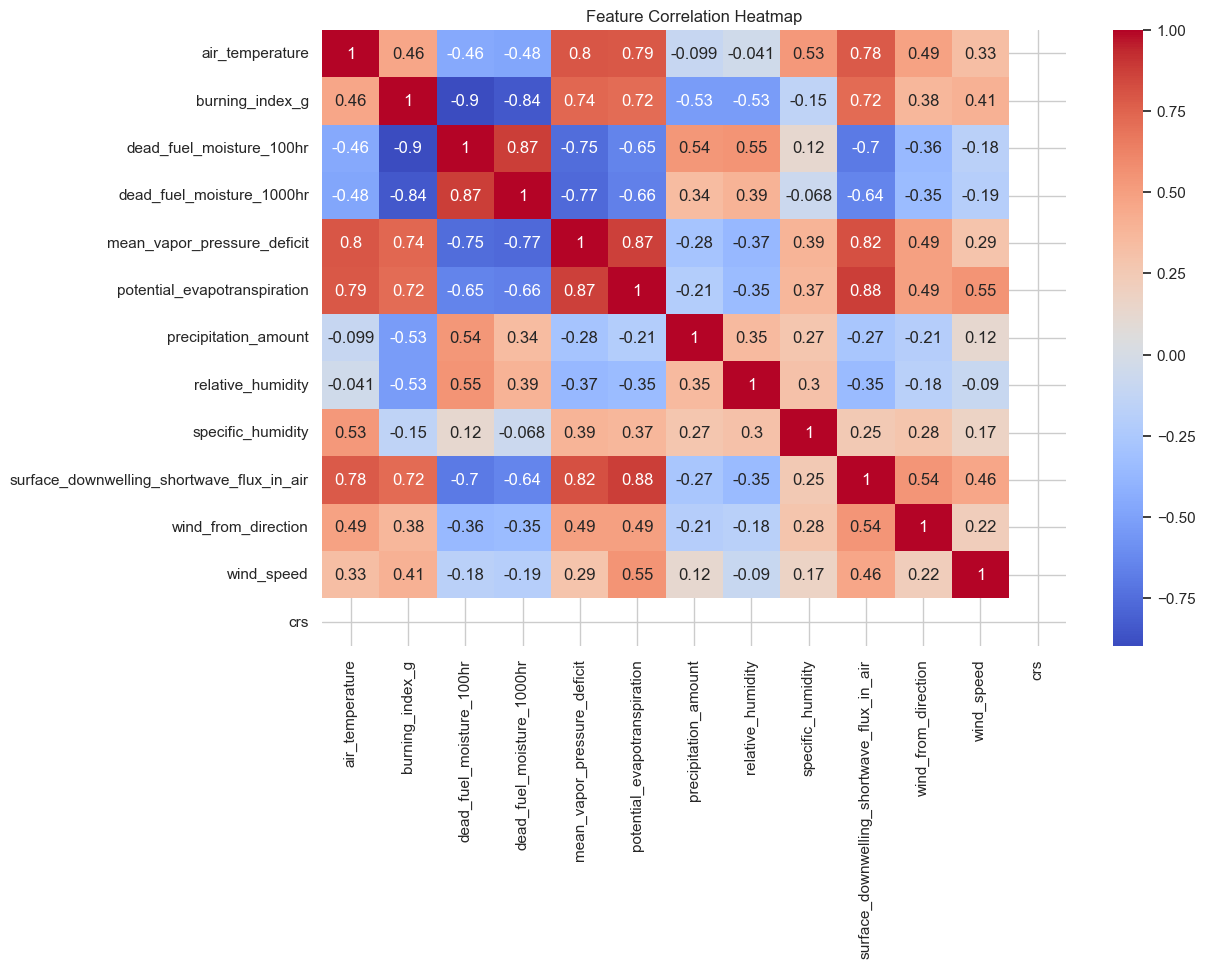

In [16]:
import seaborn as sns

# Only numeric features
numeric_cols = df_weekly.select_dtypes(include='number').drop(columns=['lat', 'lon'])
corr = numeric_cols.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")

In [17]:
import numpy as np

corr_matrix = numeric_cols.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [col for col in upper.columns if any(upper[col] > 0.85)]
numeric_cols = numeric_cols.drop(columns=to_drop)

print(f"Dropped columns: {to_drop}")

Dropped columns: ['dead_fuel_moisture_100hr', 'dead_fuel_moisture_1000hr', 'potential_evapotranspiration', 'surface_downwelling_shortwave_flux_in_air']


In [18]:
df_weekly

,time,lat,lon,air_temperature,burning_index_g,dead_fuel_moisture_100hr,dead_fuel_moisture_1000hr,mean_vapor_pressure_deficit,potential_evapotranspiration,precipitation_amount,relative_humidity,specific_humidity,surface_downwelling_shortwave_flux_in_air,wind_from_direction,wind_speed,crs
0,2017-01-01,33.900,-112.308333,281.200012,0.00,18.200001,17.600000,0.2200,1.100,9.000000,70.500000,0.006970,57.299999,165.0,3.800,0
1,2017-01-01,33.900,-112.266667,280.600006,0.00,18.800001,17.300001,0.1900,1.000,10.800000,71.200005,0.006970,56.900002,165.0,3.900,0
2,2017-01-01,33.900,-112.225000,279.299988,0.00,19.400000,17.600000,0.1300,0.900,12.800000,72.800003,0.006860,56.400002,166.0,4.000,0
3,2017-01-01,33.900,-112.183333,280.100006,0.00,19.100000,17.200001,0.1700,1.000,12.400001,72.000000,0.006860,56.000000,166.0,4.000,0
4,2017-01-01,33.900,-112.141667,280.399994,0.00,19.600000,17.700001,0.1600,1.000,15.500000,73.300003,0.006900,55.400002,166.0,4.100,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33595,2021-01-03,33.275,-112.100000,277.049988,50.25,8.700001,7.825000,0.9125,3.425,0.000000,21.724998,0.003418,123.250008,222.5,2.425,0
33596,2021-01-03,33.275,-112.058333,277.075012,50.50,8.675000,7.700000,0.8975,3.375,0.000000,22.275000,0.003422,122.925003,222.5,2.400,0
33597,2021-01-03,33.275,-112.016667,277.000000,50.50,8.750001,7.625000,0.8775,3.325,0.000000,22.800001,0.003410,123.024994,222.5,2.400,0
33598,2021-01-03,33.275,-111.975000,277.174988,50.50,8.650001,7.525000,0.8625,3.300,0.000000,23.300001,0.003407,123.125008,231.0,2.400,0


In [19]:
grouped_features = {
    'temp_humidity': ['air_temperature', 'specific_humidity', 'relative_humidity'],
    'fuel_moisture': ['dead_fuel_moisture_100hr', 'dead_fuel_moisture_1000hr'],
    'wind': ['wind_speed', 'wind_from_direction', 'mean_vapor_pressure_deficit'],
    'precip_solar': ['precipitation_amount', 'surface_downwelling_shortwave_flux_in_air'],
    'fire_risk': ['burning_index_g']  # already a single feature, but we can still scale it
}

In [20]:
aggregated_df = df_weekly[['time', 'lat', 'lon']].copy()

In [21]:
# Apply PCA to each group
for group_name, features in grouped_features.items():
    scaler = StandardScaler()
    pca = PCA(n_components=1)

    # Ensure no NaNs in the selected features
    group_data = df_weekly[features].fillna(0)
    group_scaled = scaler.fit_transform(group_data)
    aggregated_df[group_name] = pca.fit_transform(group_scaled)

In [22]:
aggregated_df

,time,lat,lon,temp_humidity,fuel_moisture,wind,precip_solar,fire_risk
0,2017-01-01,33.900,-112.308333,0.327538,4.289562,-0.821258,-5.241612,-2.814107
1,2017-01-01,33.900,-112.266667,0.308676,4.347119,-0.774596,-6.027985,-2.814107
2,2017-01-01,33.900,-112.225000,0.239730,4.529193,-0.724445,-6.902223,-2.814107
3,2017-01-01,33.900,-112.183333,0.267098,4.386274,-0.706059,-6.731782,-2.814107
4,2017-01-01,33.900,-112.141667,0.314691,4.589885,-0.650203,-8.085307,-2.814107
...,...,...,...,...,...,...,...,...
33595,2021-01-03,33.275,-112.100000,-1.646364,0.363899,-0.340704,-0.746119,-0.200455
33596,2021-01-03,33.275,-112.058333,-1.634603,0.332966,-0.362711,-0.748984,-0.187452
33597,2021-01-03,33.275,-112.016667,-1.633032,0.332378,-0.371904,-0.748102,-0.187452
33598,2021-01-03,33.275,-111.975000,-1.616487,0.291656,-0.231939,-0.747221,-0.187452


**Model Architecture**
The model is a Transformer-based neural network trained to predict a short-term future window of weather conditions and extract the residuals as a risk score.

Details:

* Input: 8-week time windows of weather variables per location

Model: Custom TransformerEncoder with:

* Linear embedding layer

* 2-layer Transformer encoder

* Linear output prediction head

Output: Predicted next week’s full weather vector

Loss: Mean Squared Error between prediction and actual values

The risk score is computed from residuals: larger errors may indicate abnormal behavior or risk.


In [23]:
import torch
from torch.utils.data import Dataset

class WeatherPredictionDataset(Dataset):
    def __init__(self, df, seq_len=8, pred_len=1):
        self.seq_len = seq_len
        self.pred_len = pred_len
        df = df.sort_values(['lat', 'lon', 'time']).reset_index(drop=True)
        self.groups = df.groupby(['lat', 'lon'])
        self.X, self.y = [], []

        for (lat, lon), group in self.groups:
            features = group.drop(columns=['time', 'lat', 'lon']).values
            for i in range(len(features) - seq_len - pred_len + 1):
                self.X.append(features[i:i+seq_len])
                self.y.append(features[i+seq_len:i+seq_len+pred_len])

        self.X = torch.tensor(self.X, dtype=torch.float32)
        self.y = torch.tensor(self.y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [24]:
import torch.nn as nn

In [25]:
class TransformerForecastModel(nn.Module):
    def __init__(self, feature_dim, hidden_dim=64, n_heads=4, n_layers=2, dropout=0.1, pred_len=1):
        super().__init__()
        self.embedding = nn.Linear(feature_dim, hidden_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=n_heads, dropout=dropout, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        self.predictor = nn.Linear(hidden_dim, feature_dim * pred_len)
        self.feature_dim = feature_dim
        self.pred_len = pred_len

    def forward(self, x):
        x = self.embedding(x)
        x = self.encoder(x)
        x = x[:, -1, :]  # last time step
        out = self.predictor(x)
        return out.view(-1, self.pred_len, self.feature_dim)

In [26]:
def compute_risk_scores(model, dataloader):
    model.eval()
    all_scores = []

    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            preds = model(X_batch)
            mse = ((preds - y_batch) ** 2).mean(dim=(1, 2))  # Mean over pred_len and features
            all_scores.extend(mse.numpy())

    return all_scores

In [27]:
def train_and_score(df, seq_len=8, pred_len=1, epochs=10, batch_size=64):
    feature_cols = [col for col in df.columns if col not in ['time', 'lat', 'lon']]
    feature_dim = len(feature_cols)

    dataset = WeatherPredictionDataset(df, seq_len, pred_len)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    model = TransformerForecastModel(feature_dim=feature_dim, pred_len=pred_len)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.MSELoss()

    print("Training model...")
    for epoch in range(epochs):
        model.train()
        for X_batch, y_batch in loader:
            preds = model(X_batch)
            loss = loss_fn(preds, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch+1}/{epochs} - Loss: {loss.item():.4f}")

    print("Scoring risk...")
    risk_scores = compute_risk_scores(model, loader)
    return risk_scores, model

In [28]:
from torch.utils.data import DataLoader
import torch.optim as optim

In [29]:
risk_scores, model = train_and_score(
    aggregated_df,    # your prepared DataFrame
    seq_len=8,        # how many weeks to look back
    pred_len=1,       # how many weeks to predict
    epochs=10,        # number of training epochs
    batch_size=64     # tune based on your memory
)

C:\Users\tomas\AppData\Local\Temp\ipykernel_20036\3420252493.py:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:278.)
  self.X = torch.tensor(self.X, dtype=torch.float32)


Training model...
Epoch 1/10 - Loss: 0.1485
Epoch 2/10 - Loss: 0.1131
Epoch 3/10 - Loss: 0.1100
Epoch 4/10 - Loss: 0.0536
Epoch 5/10 - Loss: 0.0469
Epoch 6/10 - Loss: 0.0414
Epoch 7/10 - Loss: 0.0403
Epoch 8/10 - Loss: 0.0378
Epoch 9/10 - Loss: 0.0455
Epoch 10/10 - Loss: 0.0467
Scoring risk...


In [93]:
import pickle

# Save risk scores
with open("risk_scores.pkl", "wb") as f:
    pickle.dump(risk_scores, f)

# Save the trained PyTorch model
torch.save(model.state_dict(), "risk_model.pt")

Scoring & Risk Index Creation
After training, we compute a risk score for every coordinate and week.

Steps:

* Run inference across the dataset

* Aggregate residuals (MSE) into a single score

* Rescale to 1–10 range for interpretability

* Compute std_score: standard deviation of risk over time per coordinate


In [30]:
# Extract aligned coordinate/time metadata
dataset = WeatherPredictionDataset(aggregated_df, seq_len=8, pred_len=1)
coords = []
for (lat, lon), group in aggregated_df.groupby(['lat', 'lon']):
    for i in range(len(group) - 8 - 1 + 1):  # seq_len + pred_len - 1
        coords.append((group.iloc[i+8]['time'], lat, lon))

# Rebuild DataFrame
risk_df = pd.DataFrame(coords, columns=["time", "lat", "lon"])
risk_df["risk_score"] = risk_scores

In [31]:
risk_df

,time,lat,lon,risk_score
0,2017-02-26,33.275,-112.308333,0.006236
1,2017-03-05,33.275,-112.308333,0.005082
2,2017-03-12,33.275,-112.308333,0.030824
3,2017-03-19,33.275,-112.308333,0.006672
4,2017-03-26,33.275,-112.308333,0.034504
...,...,...,...,...
32315,2020-12-06,33.900,-111.933333,0.001088
32316,2020-12-13,33.900,-111.933333,0.035155
32317,2020-12-20,33.900,-111.933333,0.082169
32318,2020-12-27,33.900,-111.933333,0.025830


In [40]:
from sklearn.preprocessing import MinMaxScaler

# Assume you have a column called 'risk_score' in your risk_by_coord dataframe
scaler = MinMaxScaler(feature_range=(1, 10))

risk_df["risk_score_scaled_1_10"] = scaler.fit_transform(
    risk_df[["risk_score"]]  # or whatever your best score is
)

In [152]:
risk_df

,time,lat,lon,risk_score,risk_score_scaled_1_10,risk_trend
0,2017-02-26,33.275,-112.308333,0.006236,1.031738,1.305095
1,2017-03-05,33.275,-112.308333,0.005082,1.025716,1.305095
2,2017-03-12,33.275,-112.308333,0.030824,1.160041,1.305095
3,2017-03-19,33.275,-112.308333,0.006672,1.034014,1.305095
4,2017-03-26,33.275,-112.308333,0.034504,1.179246,1.305095
...,...,...,...,...,...,...
32315,2020-12-06,33.900,-111.933333,0.001088,1.004875,2.156159
32316,2020-12-13,33.900,-111.933333,0.035155,1.182642,2.156159
32317,2020-12-20,33.900,-111.933333,0.082169,1.427969,2.156159
32318,2020-12-27,33.900,-111.933333,0.025830,1.133983,2.156159


In [158]:
df_std = (
    risk_df
    .groupby(['lat', 'lon'])['risk_score_scaled_1_10']
    .std()
    .reset_index(name='std_score')
)


In [166]:
df_std.to_csv('phoenix_scores.csv')

**Model Evaluation & Validation**

a. Internal Validation: Temporal Consistency
* Plotted risk scores over time for highest and lowest-risk coordinates

Verified alignment with known seasonal patterns (e.g. heat peaks in summer, dry spells in fall)

b. Spatial Smoothness Analysis
* Grouped coordinates into spatial bins
* Computed mean deviation from neighborhood risk

Result: ~0.07 average deviation — indicates stable and interpretable scores across geography

c. SHAP Explainability
* Flattened time-series features for use with SHAP
* Computed Shapley values for 100 sample sequences
* Produced summary plot showing most influential features per time step (e.g., humidity at t–1)



In [195]:
df_std.max()

lat           33.900000
lon         -111.933333
std_score      0.737127
dtype: float64

In [207]:
df_std.min()

lat           33.275000
lon         -112.308333
std_score      0.131719
dtype: float64

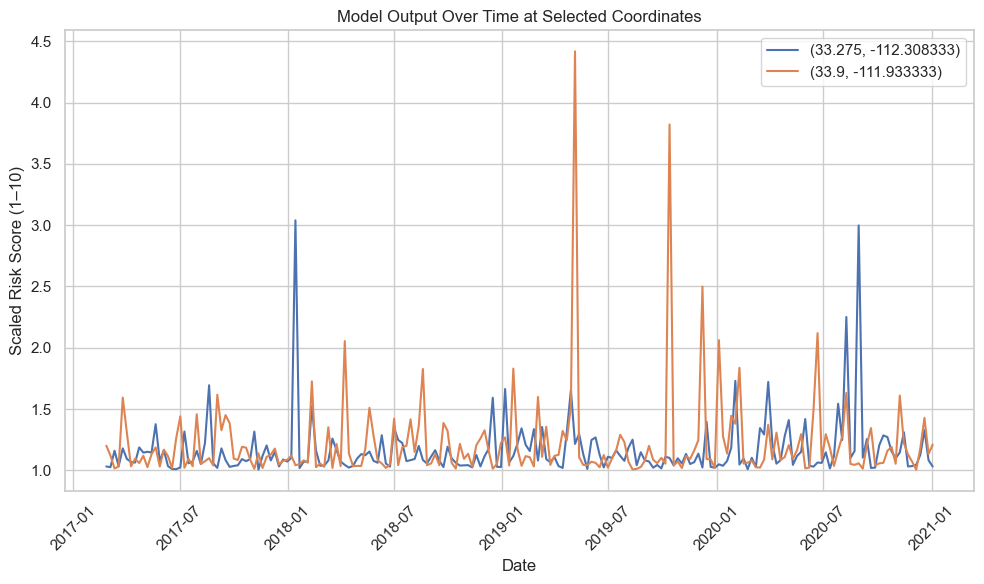

In [205]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Sample coordinates (you can change or automate later)
example_coords = [(33.275, -112.308333), (33.9, -111.933333)]

# Fuzzy filter to deal with float precision issues
def fuzzy_filter(df, target_lat, target_lon, tol=0.001):
    return df[(df['lat'].sub(target_lat).abs() < tol) & (df['lon'].sub(target_lon).abs() < tol)]

# Plotting model output over time
plt.figure(figsize=(10, 6))

for lat, lon in example_coords:
    subset = fuzzy_filter(risk_df, lat, lon).sort_values("time")

    if subset.empty:
        print(f"⚠️ No data found near ({lat}, {lon})")
        continue

    plt.plot(subset['time'], subset['risk_score_scaled_1_10'], label=f"({lat}, {lon})")

# Format plot
plt.title("Model Output Over Time at Selected Coordinates")
plt.xlabel("Date")
plt.ylabel("Scaled Risk Score (1–10)")
plt.legend()
plt.grid(True)

# Format x-axis for dates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [214]:
import pandas as pd

# Ensure df_std contains: ['lat', 'lon', 'std_score']
# If not, generate it first (from risk_df)
# df_std = risk_df.groupby(['lat', 'lon'])['risk_score_scaled_1_10'].std().reset_index(name='std_score')

# 🟢 Step 1: Bin lat/lon to coarser spatial neighborhoods
# Option 1: 0.1° bins (~11 km)
df_std['lat_bin'] = df_std['lat'].round(1)
df_std['lon_bin'] = df_std['lon'].round(1)

# 🟢 Step 2: Compute neighborhood average std_score
df_std['neighbor_avg'] = (
    df_std.groupby(['lat_bin', 'lon_bin'])['std_score']
    .transform('mean')
)

# 🟢 Step 3: Compute deviation from neighborhood average
df_std['deviation'] = (df_std['std_score'] - df_std['neighbor_avg']).abs()

# 🟢 Step 4: Print mean deviation as stability proxy
mean_deviation = df_std['deviation'].mean()
print("Average deviation from neighborhood mean:", mean_deviation)

Average deviation from neighborhood mean: 0.07166268


In [238]:
import shap
import torch

# Wrapper: SHAP expects 2D input, so flatten sequences per sample
class RiskModelWrapper:
    def __init__(self, model):
        self.model = model
        self.model.eval()

    def __call__(self, X_flat):
        # X_flat: [n_samples, seq_len * feature_dim]
        batch_size = X_flat.shape[0]
        seq_len = 8
        feature_dim = X_flat.shape[1] // seq_len

        X = X_flat.reshape(batch_size, seq_len, feature_dim)
        with torch.no_grad():
            preds = self.model(torch.tensor(X, dtype=torch.float32))
        return preds[:, 0, 0].numpy()  # assuming output shape: [B, pred_len=1, features=1]

In [240]:
# Use your training data
X_full = dataset.X.numpy()  # shape: [n_samples, seq_len, feature_dim]
X_flat = X_full.reshape(X_full.shape[0], -1)

# Subsample for performance
background = X_flat[np.random.choice(len(X_flat), 100, replace=False)]
explainer = shap.Explainer(RiskModelWrapper(model), background)

PermutationExplainer explainer: 101it [20:34, 12.34s/it]                                                               
C:\Users\tomas\AppData\Local\Temp\ipykernel_20036\1395026964.py:4: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


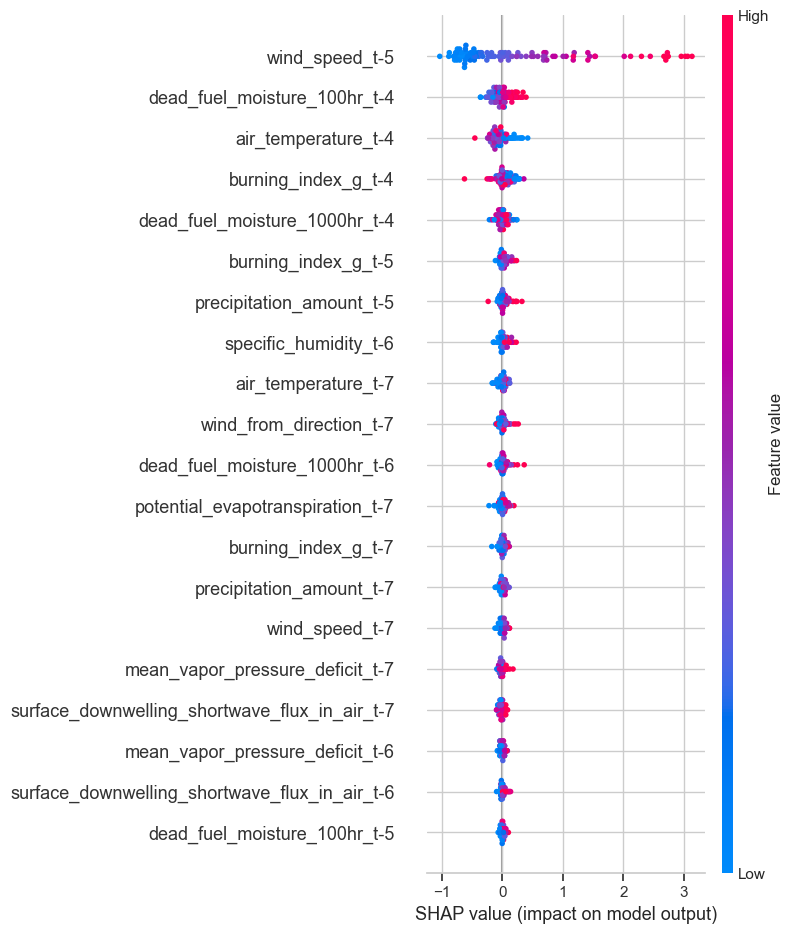

In [246]:
X_sample = X_flat[:100]
shap_values = explainer(X_sample)

shap.summary_plot(
    shap_values.values,
    features=X_sample,
    feature_names=[f"{v}_t-{i}" for i in range(8)[::-1] for v in VARIABLES]
)